In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

sns.set_style("darkgrid")

2023-06-28 13:42:58.021346: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 13:42:58.490986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-28 13:42:58.491028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-28 13:42:58.492342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-28 13:42:58.672148: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 13:42:58.675207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
from utils import LowRankDense

get_custom_objects().update({'LowRankDense': LowRankDense})

In [3]:
model = tf.keras.models.load_model('models/CNNOneTStride8Attention.h5')


In [4]:
from dataset import DataLoader, DataVisualizer, DatasetBuilder
data = DataLoader(path='DATA/speech_commands_v0.02')
commands = data.get_commands()
filenames = data.get_filenames()
train_files, val_files, test_files = data.split_data(filenames)
ds = DatasetBuilder(
    commands=commands,
    train_filenames=train_files,
    val_filenames=val_files,
    test_filenames=test_files,
    batch_size=64,
    buffer_size=1000,
    #method='log_mel',
    method = 'STFT',
)

train, test, val = ds.preprocess_dataset_spectrogram()
train_waveforms = data.get_waveform_ds(train_files)
#train_spectrograms = data.get_spectrogram_logmel_ds(
#    train_waveforms,
#    commands
#)

train_spectrograms = data.get_spectrogram_STFT_ds(
    train_waveforms,
    commands
)

Dataset path:  DATA/speech_commands_v0.02


In [5]:
for i in range(len(model.layers)):
    print(i, model.layers[i].name)

0 input_1
1 resizing
2 normalization
3 conv2d
4 max_pooling2d
5 conv2d_1
6 max_pooling2d_1
7 attention
8 flatten
9 low_rank_dense
10 dense
11 dense_1
12 dense_2


Label:  18


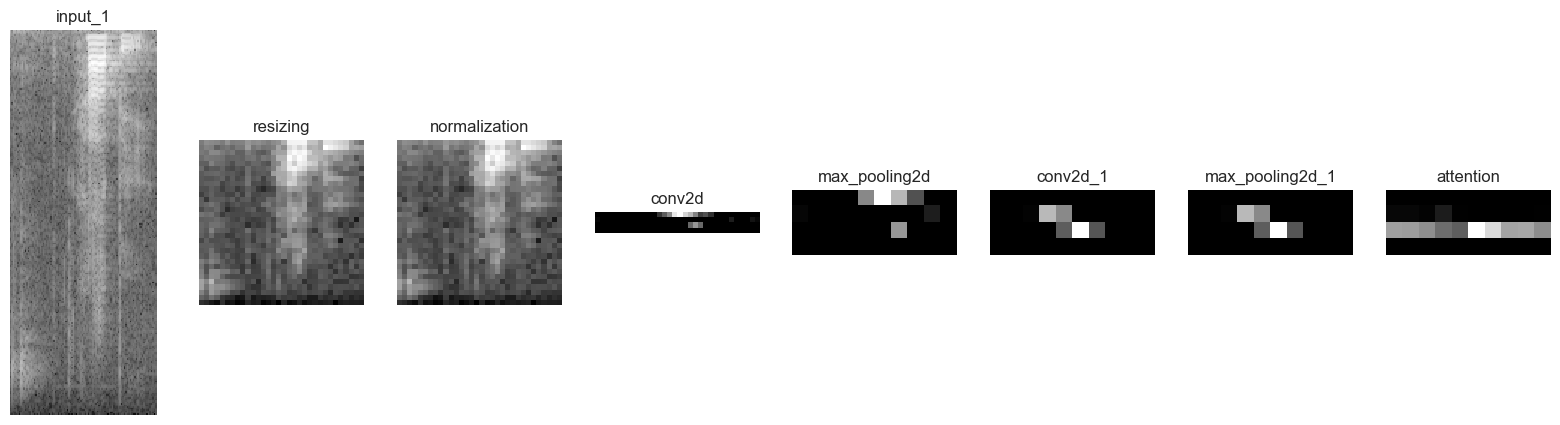

Label:  13


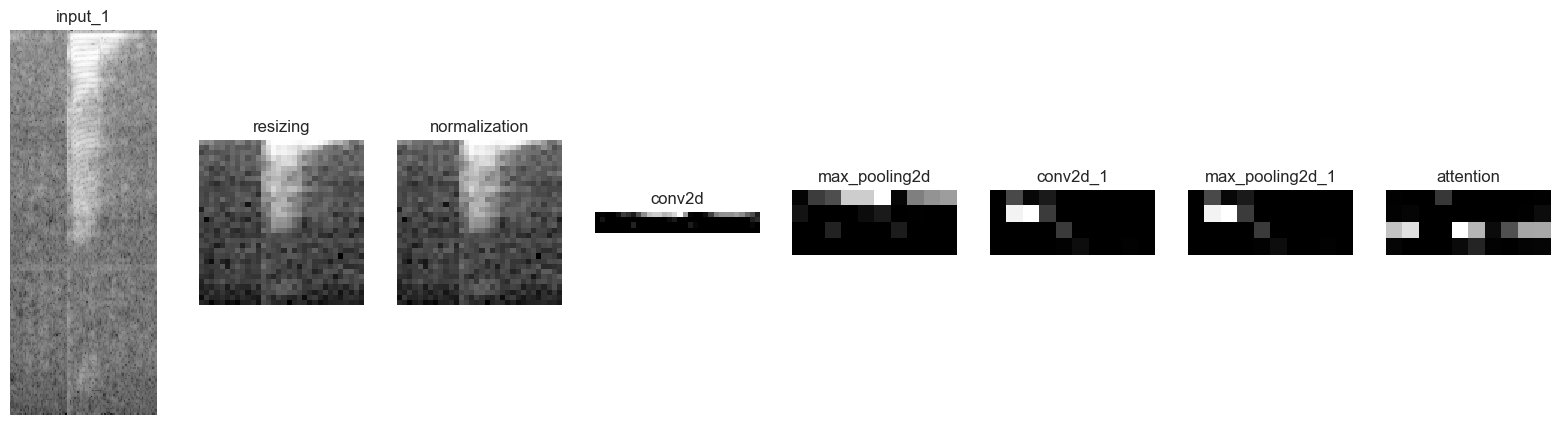

Label:  5


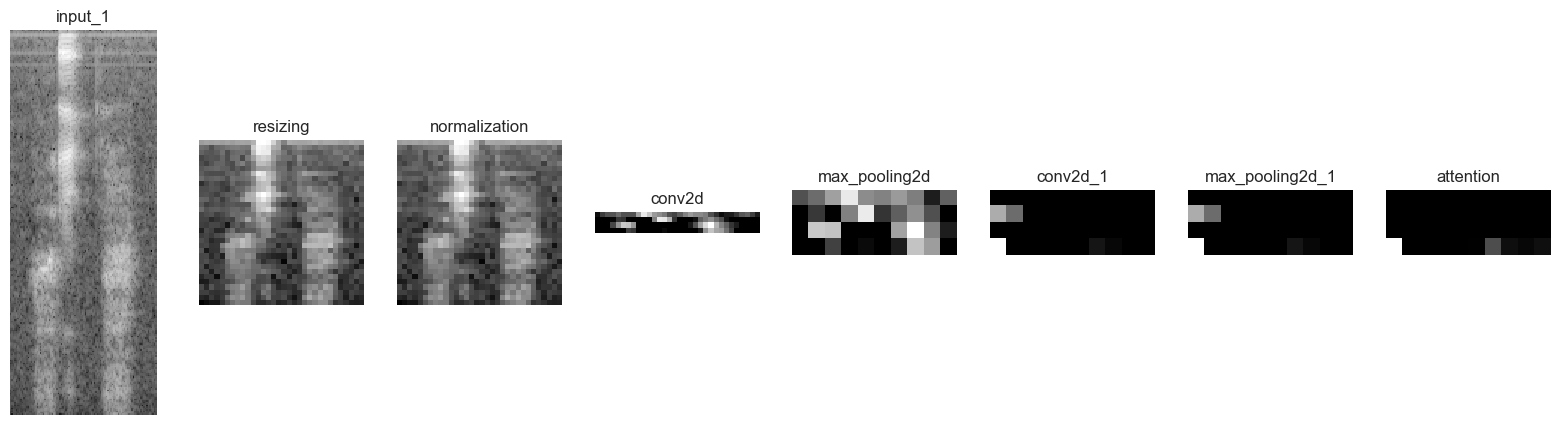

Label:  20


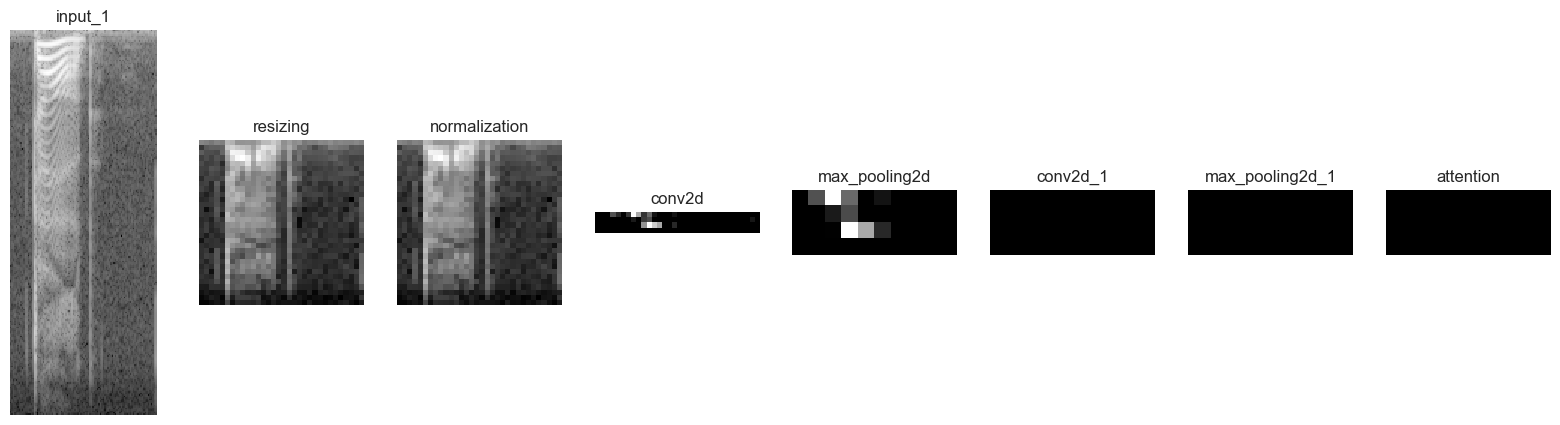

Label:  20


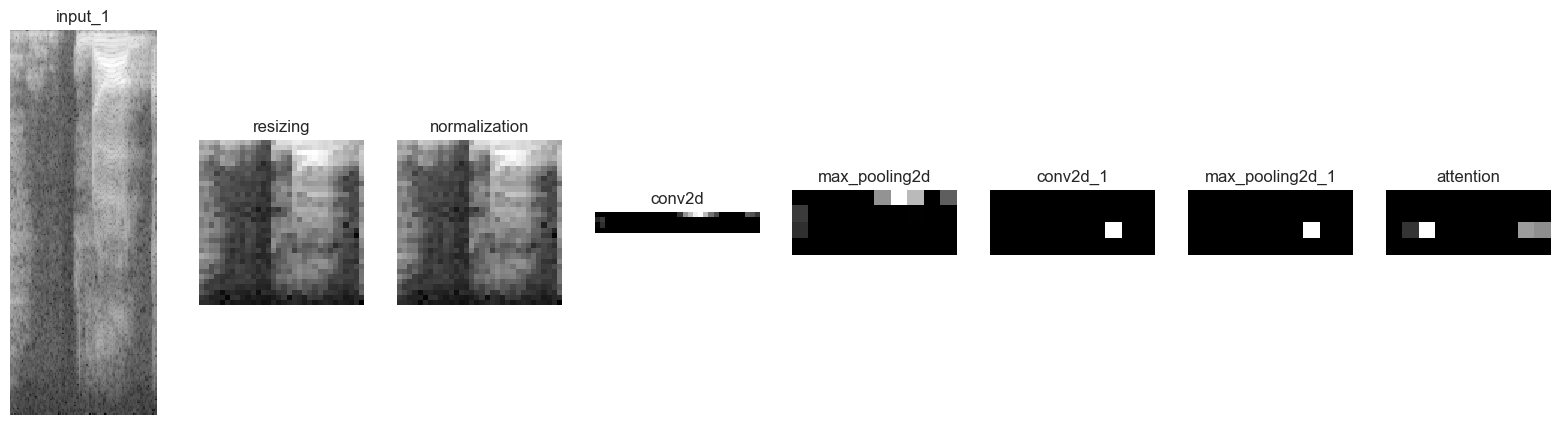

Label:  4


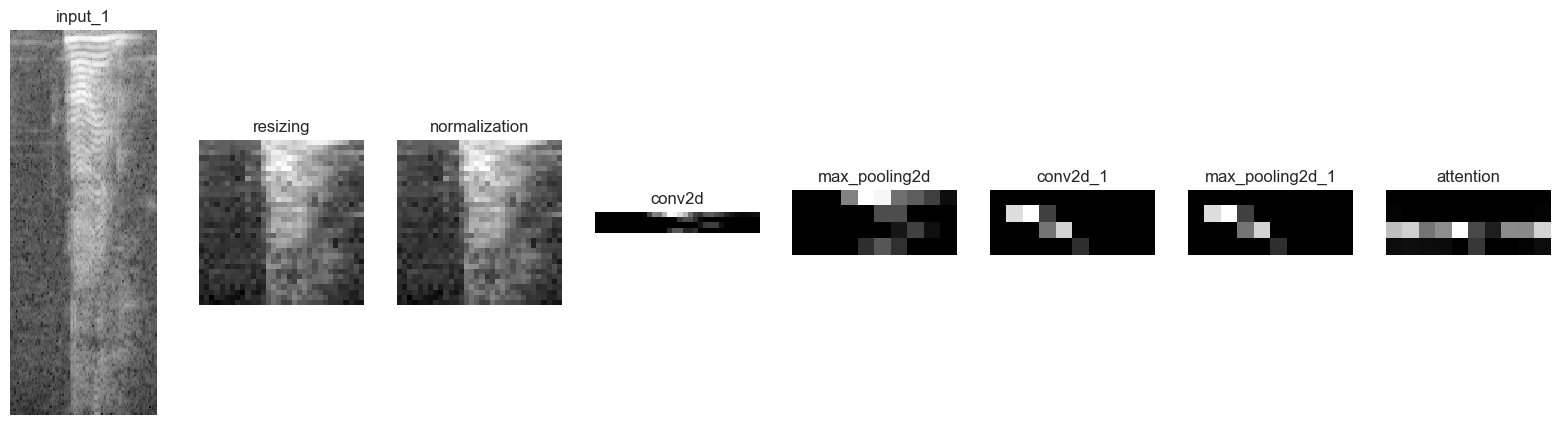

Label:  26


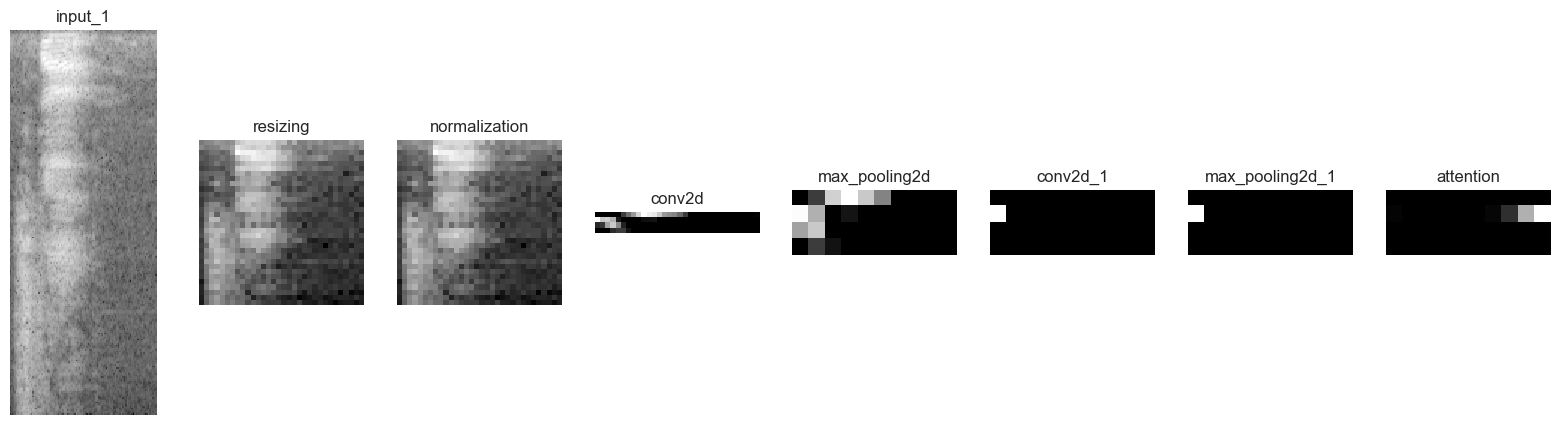

Label:  8


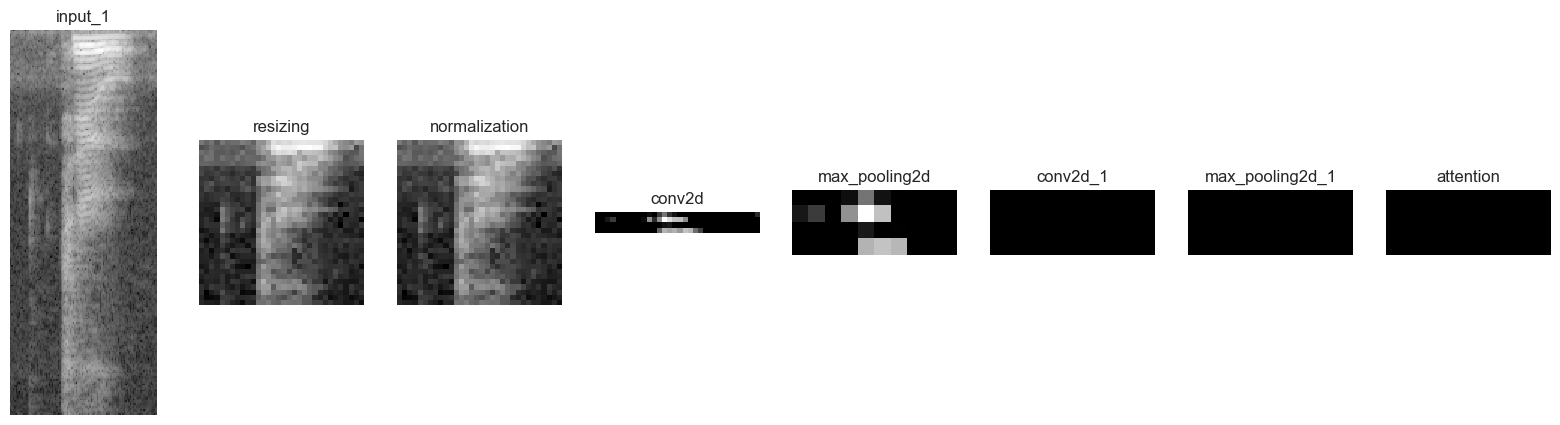

Label:  32


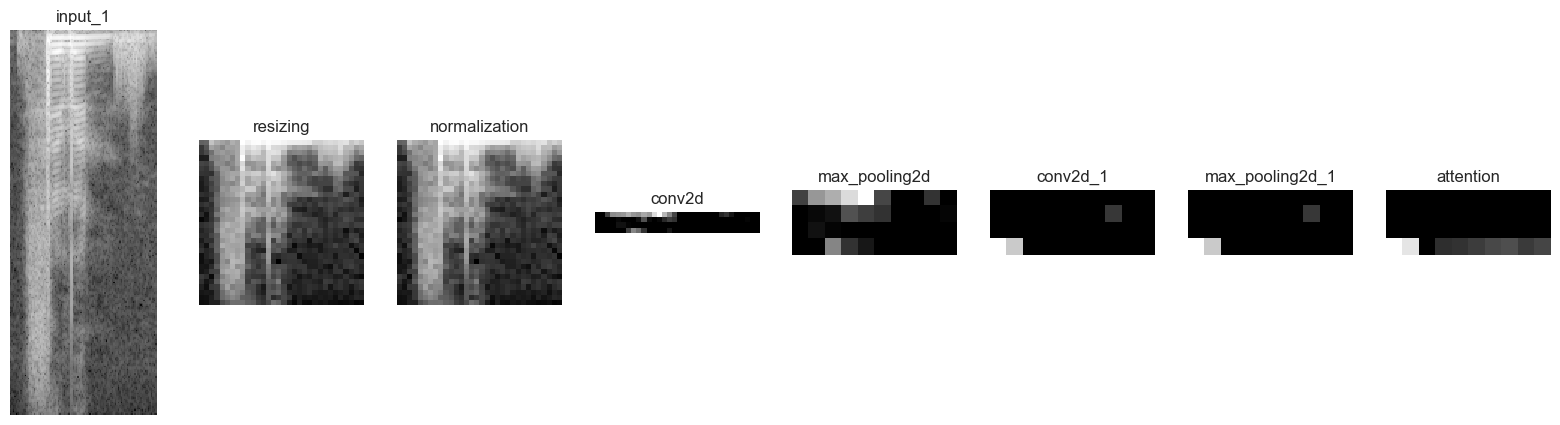

Label:  31


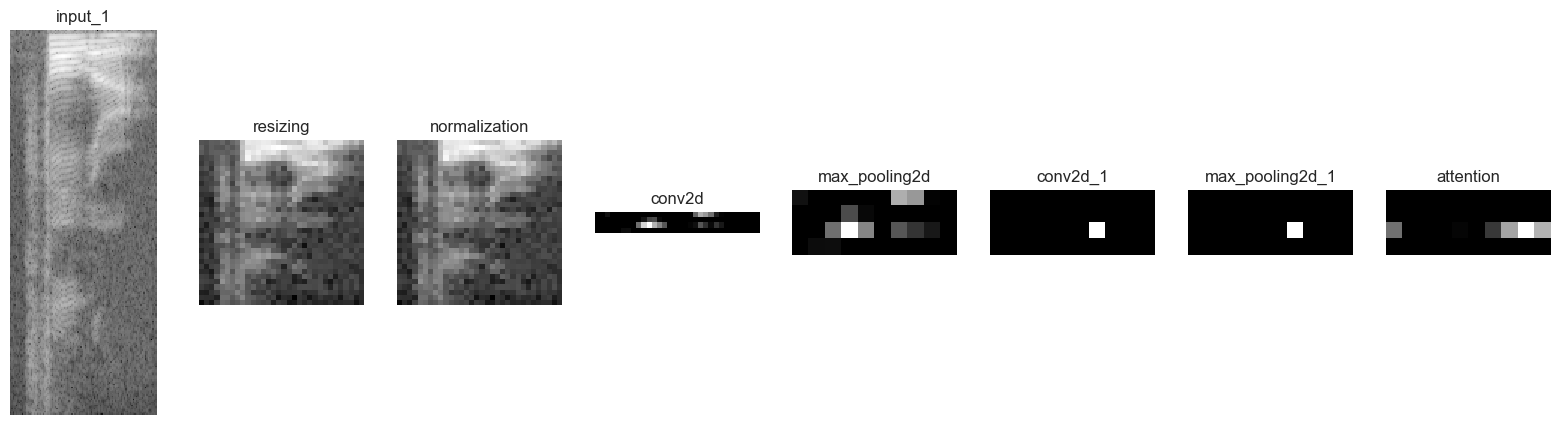

In [7]:
import os
for spec, label in train_spectrograms.take(10):
    print("Label: ", label.numpy())
    # unsqueeze the last axis for channel
    input_image = tf.expand_dims(tf.expand_dims(spec, -1), 0)

    layer_index = 0
    layer = model.layers[layer_index]

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))

    for i in range(8):
        feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[i].output)
        features = feature_extractor(input_image)

        axs[i].set_title(model.layers[i].name)
        axs[i].imshow(features.numpy()[0, :, :, 0], cmap='gray', interpolation='nearest')#, aspect='auto')
        axs[i].axis('off')
    
    plt.show()
    if os.path.isdir('figures/feature_maps') == False:
        os.mkdir('figures/feature_maps')
    fig.savefig('figures/feature_maps/feature_maps_{}.pdf'.format(label.numpy()))